**Exercise:**

Utilize the Iris flower dataset from sklearn.datasets to train various classifier models. Evaluate the accuracy of each model and utilize them for predicting samples in your test dataset. Additionally, employ cross_val_score to assess the performance of each model. Identify the optimal model and hyperparameters using GridSearchCV. The Iris dataset comprises 150 samples with the following attributes:

* Sepal Length
* Sepal Width
* Petal Length
* Petal Width
  
Based on these four features, classify each flower into one of the following three categories:

* Setosa
* Versicolour
* Virginica


In [2]:
# Import necessary libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.cluster import KMeans

# Enable inline plotting for Jupyter notebooks.
%matplotlib inline

# Suppress user warnings if necessary.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Load the dataset.
iris = load_iris()

# Display dataset attributes.
print(dir(iris))

['DESCR', 'data', 'data_module', 'feature_names', 'filename', 'frame', 'target', 'target_names']


In [4]:
# Display feature names and target names.
print(f"Feature names: {iris.feature_names}")
print(f"Target names: {iris.target_names}")

Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']


In [5]:
# Create a dataframe from the dataset.
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df['flower_name'] = df.target.apply(lambda x: iris.target_names[x])

In [6]:
# Display the first 5 rows of the dataframe.
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,flower_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [7]:
# Get the shape of the dataset.
num_rows, num_columns = df.shape

# Format the output and print it.
output = (
    f"Dataset Overview\n"
    f"{'-'*30}\n"
    f"Number of Rows    : {num_rows}\n"
    f"Number of Columns : {num_columns}\n"
    f"{'-'*30}"
)

print(output)

Dataset Overview
------------------------------
Number of Rows    : 150
Number of Columns : 6
------------------------------


## Data Exploration, Visualization and Preprocessing:

In [9]:
# Display a summary of statistics for each column in the dataframe.
# This includes count, mean, std deviation, min, 25%, 50%, 75%, and max values.
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [10]:
# Get value counts of the 'target' column to identify whether the dataset is imbalanced or not.
value_counts = df['target'].value_counts()

# Display the value counts.
print("Value counts of the 'target' column:\n")
print(value_counts)

Value counts of the 'target' column:

target
0    50
1    50
2    50
Name: count, dtype: int64


In [11]:
def remove_outliers(df: pd.DataFrame, columns: list, z_threshold: float = 3.0) -> pd.DataFrame:
    """
    Removes outliers from the dataframe based on the Z-score method.

    Parameters:
    - df: pd.DataFrame
        The input dataframe containing the data.
    - columns: list
        List of column names to check for outliers.
    - z_threshold: float
        The Z-score threshold to identify outliers (default is 3.0).

    Returns:
    - pd.DataFrame
        A new dataframe with outliers removed.
    """
    # Calculate Z-scores for specified columns.
    z_scores = df[columns].apply(lambda col: (col - col.mean()) / col.std())

    # Create a boolean mask where all z-scores are within the threshold.
    mask = (z_scores.abs() < z_threshold).all(axis=1)

    # Return the dataframe with outliers removed.
    return df[mask]

In [12]:
# Define the columns to check for outliers.
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()

# Check if 'target' exists in numerical_columns and remove it if present.
if 'target' in numerical_columns:
    numerical_columns.remove('target')

# Remove outliers if they exist.
df_cleaned = remove_outliers(df, numerical_columns)

# Print the number of rows before and after removing outliers.
print(f"Original number of rows: {df.shape[0]}")
print(f"Number of rows after removing outliers: {df_cleaned.shape[0]}")

Original number of rows: 150
Number of rows after removing outliers: 149


In [13]:
# Separate the dataframe into Setosa, Versicolor and Virginica classes.
df_setosa = df_cleaned[df_cleaned['target'] == 0]
df_versicolor = df_cleaned[df_cleaned['target'] == 1]
df_virginica = df_cleaned[df_cleaned['target'] == 2]

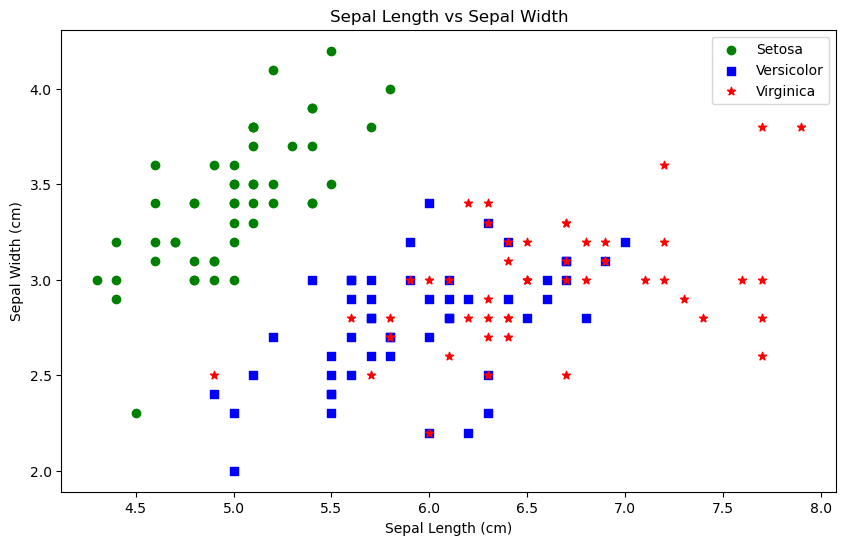

In [14]:
# Plot sepal length vs sepal width for all classes.
plt.figure(figsize=(10, 6))
plt.title('Sepal Length vs Sepal Width')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.scatter(df_setosa['sepal length (cm)'], df_setosa['sepal width (cm)'], color="green", marker='o', label='Setosa')
plt.scatter(df_versicolor['sepal length (cm)'], df_versicolor['sepal width (cm)'], color="blue", marker='s', label='Versicolor')
plt.scatter(df_virginica['sepal length (cm)'], df_virginica['sepal width (cm)'], color="red", marker='*', label='Virginica')
plt.legend()
plt.grid(False)
plt.show()

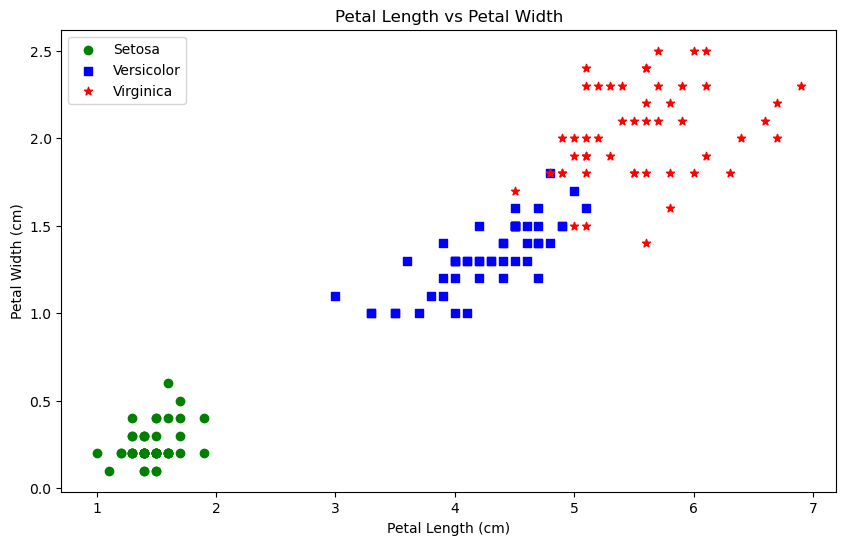

In [15]:
# Plot petal length vs petal width for all classes.
plt.figure(figsize=(10, 6))
plt.title('Petal Length vs Petal Width')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.scatter(df_setosa['petal length (cm)'], df_setosa['petal width (cm)'], color="green", marker='o', label='Setosa')
plt.scatter(df_versicolor['petal length (cm)'], df_versicolor['petal width (cm)'], color="blue", marker='s', label='Versicolor')
plt.scatter(df_virginica['petal length (cm)'], df_virginica['petal width (cm)'], color="red", marker='*', label='Virginica')
plt.legend()
plt.grid(False)
plt.show()

## Model Training and Prediction:

In [17]:
# Prepare the data for training.
X = df_cleaned.drop(['target', 'flower_name'], axis='columns') # Features (independent variable)
y = df_cleaned['target']                                       # Target   (dependent variable)

# Display the first 5 rows of features.
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [18]:
# Display the first 5 rows of the target variable.
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int32

In [19]:
# Split the dataset into training and testing sets.
# X_train: Training set features.
# X_test: Testing set features.
# y_train: Training set target variable.
# y_test: Testing set target variable.
# test_size=0.2: 20% of the data will be used for testing, 80% for training.
# stratify=y: Ensures the target variable 'y' is evenly distributed in both training and testing sets. It should be used in case of an imbalanced dataset.
# random_state=42: Ensures reproducibility of the split.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, stratify=None, random_state=42)

# Print the number of samples in training and testing sets.
print(f"{'Training set size':<20}: {len(X_train)} samples")
print(f"{'Testing set size':<20}: {len(X_test)} samples")

Training set size   : 119 samples
Testing set size    : 30 samples


In [20]:
# Create an instance of StandardScaler.
scaler = StandardScaler()

# Fit the scaler on the training data and transform it.
# This computes the mean and standard deviation on X_train and then scales X_train accordingly.
X_train_scaled_array = scaler.fit_transform(X_train)

# Use the previously computed mean and standard deviation to scale the test data.
X_test_scaled_array = scaler.transform(X_test)

# Convert the scaled arrays back to dataframes.
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X_test.columns, index=X_test.index)

### 1) Logistic Regression

In [22]:
# Instantiate and train the logistic regression model.
# Increase max_iter from default which is 100.
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [23]:
# Compute and print the training score of the trained model.
train_score = log_reg.score(X_train_scaled, y_train)
print(f"The training score is: {train_score:.3f}")

# Compute and print the testing score of the trained model.
test_score = log_reg.score(X_test_scaled, y_test)
print(f"The testing score is: {test_score:.3f}")

The training score is: 0.992
The testing score is: 0.900


In [24]:
# Initialize StratifiedKFold and split the dataset into n_splits equal parts by shuffling the data before splitting into folds to ensure random distribution of samples.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation using cross_val_score.
cv_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=skf, scoring='accuracy')

# Print the average cross-validation accuracy scores.
print(f"The logistic regression model's average cross-validation accuracy using StratifiedKFold: {np.mean(cv_scores):.3f}")

The logistic regression model's average cross-validation accuracy using StratifiedKFold: 0.965


In [25]:
# Make predictions on the test data.
y_predicted = log_reg.predict(X_test_scaled)

# Convert X_test to a dataframe (assuming X_test is a NumPy array or DataFrame).
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test_scaled.columns)

# Add 'Predicted Class' column to X_test_df.
X_test_df['Predicted Class'] = [iris.target_names[p] for p in y_predicted]

# Display the first few rows of the concatenated dataframe.
X_test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Predicted Class
74,0.712269,-0.314362,0.314902,0.138939,versicolor
19,-0.857361,1.789898,-1.289462,-1.205270,setosa
118,2.281900,-1.015782,1.804669,1.483149,virginica
79,-0.132916,-1.015782,-0.143488,-0.264324,versicolor
77,1.074492,-0.080555,0.715993,0.676623,virginica


In [26]:
# Make probability predictions on the test data.
y_proba = log_reg.predict_proba(X_test_scaled)

# Convert the predicted probabilities to a dataframe.
proba_df = pd.DataFrame(y_proba, columns=[iris.target_names[c] for c in log_reg.classes_], index=X_test_scaled.index)

# Display the first few rows of the formatted probability predictions.
proba_df.head()

,setosa,versicolor,virginica
74,1.040730e-02,0.907662,8.193101e-02
19,9.911462e-01,0.008854,1.315133e-07
118,3.655329e-08,0.003622,9.963775e-01
79,4.713529e-02,0.942196,1.066833e-02
77,1.308094e-03,0.440319,5.583727e-01


### 2) Decision Tree

In [28]:
# Initialize and train the decision tree classifier.
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [29]:
# Compute and print the training score of the trained model.
train_score = dec_tree.score(X_train_scaled, y_train)
print(f"The training score is: {train_score:.3f}")

# Compute and print the testing score of the trained model.
test_score = dec_tree.score(X_test_scaled, y_test)
print(f"The testing score is: {test_score:.3f}")

The training score is: 1.000
The testing score is: 0.900


In [30]:
# Initialize StratifiedKFold and split the dataset into n_splits equal parts by shuffling the data before splitting into folds to ensure random distribution of samples.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation using cross_val_score.
cv_scores = cross_val_score(dec_tree, X_train_scaled, y_train, cv=skf, scoring='accuracy')

# Print the average cross-validation accuracy scores.
print(f"The decision tree model's average cross-validation accuracy using StratifiedKFold: {np.mean(cv_scores):.3f}")

The decision tree model's average cross-validation accuracy using StratifiedKFold: 0.973


In [31]:
# Make predictions on the test data.
y_predicted = dec_tree.predict(X_test_scaled)

# Convert X_test to a dataframe (assuming X_test is a NumPy array or DataFrame).
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test_scaled.columns)

# Add 'Predicted Class' column to X_test_df.
X_test_df['Predicted Class'] = [iris.target_names[p] for p in y_predicted]

# Display the first few rows of the concatenated dataframe.
X_test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Predicted Class
74,0.712269,-0.314362,0.314902,0.138939,versicolor
19,-0.857361,1.789898,-1.289462,-1.205270,setosa
118,2.281900,-1.015782,1.804669,1.483149,virginica
79,-0.132916,-1.015782,-0.143488,-0.264324,versicolor
77,1.074492,-0.080555,0.715993,0.676623,virginica


In [32]:
# Make probability predictions on the test data.
y_proba = dec_tree.predict_proba(X_test_scaled)

# Convert the predicted probabilities to a dataframe.
proba_df = pd.DataFrame(y_proba, columns=[iris.target_names[c] for c in log_reg.classes_], index=X_test_scaled.index)

# Display the first few rows of the formatted probability predictions.
proba_df.head()

,setosa,versicolor,virginica
74,0.0,1.0,0.0
19,1.0,0.0,0.0
118,0.0,0.0,1.0
79,0.0,1.0,0.0
77,0.0,0.0,1.0


### 3) Support Vector Machine

In [34]:
# Initialize and train the support vector machine classifier.
# SVC Parameters:
# - Regularization parameter (C): Controls the trade-off between maximizing the margin and minimizing the classification error.
#   Higher values of C emphasize classifying points correctly over wider margins, potentially leading to overfitting.
#   Lower values of C promote wider margins, which may generalize better but could increase classification errors.
#   Example: C = 1.0

# - Kernel type: Specifies the type of kernel function used for mapping inputs into higher-dimensional space.
#   Common choices include linear, polynomial, radial basis function (RBF), and sigmoid kernels.
#   Each kernel type influences the decision boundary's flexibility and complexity.
#   Example: kernel='rbf' for RBF kernel

# - Gamma parameter: Influences the kernel coefficient for 'rbf', 'poly', and 'sigmoid' kernels.
#   Higher gamma values lead to more complex decision boundaries, potentially resulting in overfitting.
#   Lower gamma values make the decision boundary smoother, promoting better generalization.
#   Example: gamma = 'scale', 'auto', or a specific float value
svm = SVC()
svm.fit(X_train_scaled, y_train)

SVC()

In [35]:
# Compute and print the training score of the trained model.
train_score = svm.score(X_train_scaled, y_train)
print(f"The training score is: {train_score:.3f}")

# Compute and print the testing score of the trained model.
test_score = svm.score(X_test_scaled, y_test)
print(f"The testing score is: {test_score:.3f}")

The training score is: 0.983
The testing score is: 0.933


In [36]:
# Initialize StratifiedKFold and split the dataset into n_splits equal parts by shuffling the data before splitting into folds to ensure random distribution of samples.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation using cross_val_score.
cv_scores = cross_val_score(svm, X_train_scaled, y_train, cv=skf, scoring='accuracy')

# Print the average cross-validation accuracy scores.
print(f"The support vector machine model's average cross-validation accuracy using StratifiedKFold: {np.mean(cv_scores):.3f}")

The support vector machine model's average cross-validation accuracy using StratifiedKFold: 0.973


In [37]:
# Make predictions on the test data.
y_predicted = svm.predict(X_test_scaled)

# Convert X_test to a dataframe (assuming X_test is a NumPy array or DataFrame).
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test_scaled.columns)

# Add 'Predicted Class' column to X_test_df.
X_test_df['Predicted Class'] = [iris.target_names[p] for p in y_predicted]

# Display the first few rows of the concatenated dataframe.
X_test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Predicted Class
74,0.712269,-0.314362,0.314902,0.138939,versicolor
19,-0.857361,1.789898,-1.289462,-1.205270,setosa
118,2.281900,-1.015782,1.804669,1.483149,virginica
79,-0.132916,-1.015782,-0.143488,-0.264324,versicolor
77,1.074492,-0.080555,0.715993,0.676623,virginica


### 4) Random Forest

In [39]:
# Initialize and train the random forest classifier.
# RandomForestClassifier Parameters:
# - n_estimators: The number of trees in the forest.
#   Increasing the number of trees can improve the model's performance as more trees allow for a more robust
#   representation of the data, but it also increases computation time and memory usage.
#   Lower values may lead to underfitting, where the model does not capture the data complexity.
#   Example: n_estimators = 100
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [40]:
# Compute and print the training score of the trained model.
train_score = rf.score(X_train_scaled, y_train)
print(f"The training score is: {train_score:.3f}")

# Compute and print the testing score of the trained model.
test_score = rf.score(X_test_scaled, y_test)
print(f"The testing score is: {test_score:.3f}")

The training score is: 1.000
The testing score is: 0.900


In [41]:
# Initialize StratifiedKFold and split the dataset into n_splits equal parts by shuffling the data before splitting into folds to ensure random distribution of samples.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation using cross_val_score.
cv_scores = cross_val_score(rf, X_train_scaled, y_train, cv=skf, scoring='accuracy')

# Print the average cross-validation accuracy scores.
print(f"The random forest model's average cross-validation accuracy using StratifiedKFold: {np.mean(cv_scores):.3f}")

The random forest model's average cross-validation accuracy using StratifiedKFold: 0.965


In [42]:
# Make predictions on the test data.
y_predicted = rf.predict(X_test_scaled)

# Convert X_test to a dataframe (assuming X_test is a NumPy array or DataFrame).
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test_scaled.columns)

# Add 'Predicted Class' column to X_test_df.
X_test_df['Predicted Class'] = [iris.target_names[p] for p in y_predicted]

# Display the first few rows of the concatenated dataframe.
X_test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Predicted Class
74,0.712269,-0.314362,0.314902,0.138939,versicolor
19,-0.857361,1.789898,-1.289462,-1.205270,setosa
118,2.281900,-1.015782,1.804669,1.483149,virginica
79,-0.132916,-1.015782,-0.143488,-0.264324,versicolor
77,1.074492,-0.080555,0.715993,0.676623,virginica


In [43]:
# Make probability predictions on the test data.
y_proba = rf.predict_proba(X_test_scaled)

# Convert the predicted probabilities to a dataframe.
proba_df = pd.DataFrame(y_proba, columns=[iris.target_names[c] for c in log_reg.classes_], index=X_test_scaled.index)

# Display the first few rows of the formatted probability predictions.
proba_df.head()

,setosa,versicolor,virginica
74,0.0,0.99,0.01
19,1.0,0.00,0.00
118,0.0,0.00,1.00
79,0.0,1.00,0.00
77,0.0,0.12,0.88


### 5) Naive Bayes

In [45]:
# Initialize and train the gaussian naive bayes classifier.
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)

GaussianNB()

In [46]:
# Compute and print the training score of the trained model.
train_score = gnb.score(X_train_scaled, y_train)
print(f"The training score is: {train_score:.3f}")

# Compute and print the testing score of the trained model.
test_score = gnb.score(X_test_scaled, y_test)
print(f"The testing score is: {test_score:.3f}")

The training score is: 0.966
The testing score is: 0.867


In [47]:
# Initialize StratifiedKFold and split the dataset into n_splits equal parts by shuffling the data before splitting into folds to ensure random distribution of samples.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation using cross_val_score.
cv_scores = cross_val_score(gnb, X_train_scaled, y_train, cv=skf, scoring='accuracy')

# Print the average cross-validation accuracy scores.
print(f"The gaussian naive bayes model's average cross-validation accuracy using StratifiedKFold: {np.mean(cv_scores):.3f}")

The gaussian naive bayes model's average cross-validation accuracy using StratifiedKFold: 0.965


In [48]:
# Make predictions on the test data.
y_predicted = gnb.predict(X_test_scaled)

# Convert X_test to a dataframe (assuming X_test is a NumPy array or DataFrame).
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test_scaled.columns)

# Add 'Predicted Class' column to X_test_df.
X_test_df['Predicted Class'] = [iris.target_names[p] for p in y_predicted]

# Display the first few rows of the concatenated dataframe.
X_test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Predicted Class
74,0.712269,-0.314362,0.314902,0.138939,versicolor
19,-0.857361,1.789898,-1.289462,-1.205270,setosa
118,2.281900,-1.015782,1.804669,1.483149,virginica
79,-0.132916,-1.015782,-0.143488,-0.264324,versicolor
77,1.074492,-0.080555,0.715993,0.676623,virginica


In [49]:
# Make probability predictions on the test data.
y_proba = gnb.predict_proba(X_test_scaled)

# Convert the predicted probabilities to a dataframe.
proba_df = pd.DataFrame(y_proba, columns=[iris.target_names[c] for c in log_reg.classes_], index=X_test_scaled.index)

# Display the first few rows of the formatted probability predictions.
proba_df.head()

,setosa,versicolor,virginica
74,8.176743e-78,9.981611e-01,1.838921e-03
19,1.000000e+00,3.300604e-21,7.408884e-23
118,1.043437e-285,9.168621e-17,1.000000e+00
79,1.075796e-38,9.999941e-01,5.858028e-06
77,9.062677e-128,2.936790e-02,9.706321e-01


### 6) K-Nearest Neighbors

In [51]:
# Initialize and train the k-nearest neighbors classifier.
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [52]:
# Compute and print the training score of the trained model.
train_score = knn.score(X_train_scaled, y_train)
print(f"The training score is: {train_score:.3f}")

# Compute and print the testing score of the trained model.
test_score = knn.score(X_test_scaled, y_test)
print(f"The testing score is: {test_score:.3f}")

The training score is: 0.975
The testing score is: 0.933


In [53]:
# Initialize StratifiedKFold and split the dataset into n_splits equal parts by shuffling the data before splitting into folds to ensure random distribution of samples.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation using cross_val_score.
cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=skf, scoring='accuracy')

# Print the average cross-validation accuracy scores.
print(f"The k-nearest neighbor model's average cross-validation accuracy using StratifiedKFold: {np.mean(cv_scores):.3f}")

The k-nearest neighbor model's average cross-validation accuracy using StratifiedKFold: 0.965


In [54]:
# Make predictions on the test data.
y_predicted = knn.predict(X_test_scaled)

# Convert X_test to a dataframe (assuming X_test is a NumPy array or DataFrame).
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test_scaled.columns)

# Add 'Predicted Class' column to X_test_df.
X_test_df['Predicted Class'] = [iris.target_names[p] for p in y_predicted]

# Display the first few rows of the concatenated dataframe.
X_test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Predicted Class
74,0.712269,-0.314362,0.314902,0.138939,versicolor
19,-0.857361,1.789898,-1.289462,-1.205270,setosa
118,2.281900,-1.015782,1.804669,1.483149,virginica
79,-0.132916,-1.015782,-0.143488,-0.264324,versicolor
77,1.074492,-0.080555,0.715993,0.676623,versicolor


In [55]:
# Make probability predictions on the test data.
y_proba = knn.predict_proba(X_test_scaled)

# Convert the predicted probabilities to a dataframe.
proba_df = pd.DataFrame(y_proba, columns=[iris.target_names[c] for c in log_reg.classes_], index=X_test_scaled.index)

# Display the first few rows of the formatted probability predictions.
proba_df.head()

,setosa,versicolor,virginica
74,0.0,1.0,0.0
19,1.0,0.0,0.0
118,0.0,0.0,1.0
79,0.0,1.0,0.0
77,0.0,0.6,0.4


### 7) Confusion Matrices and Classification Reports for All Supervised Models

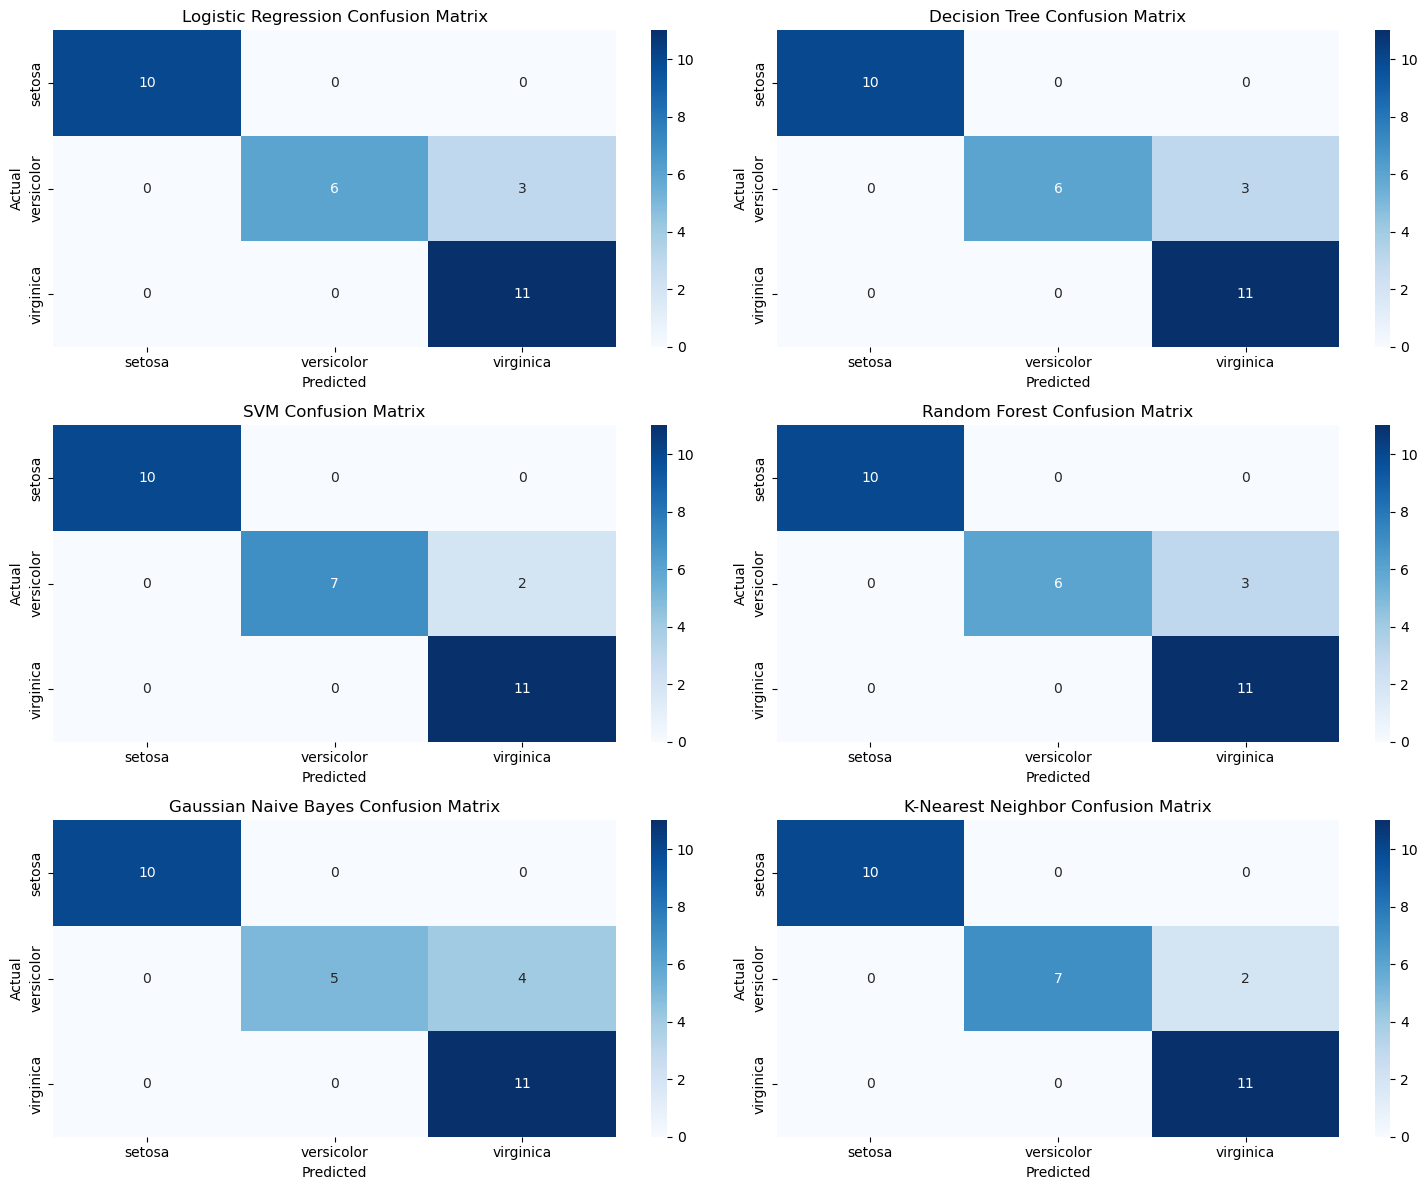

In [57]:
# Make predictions on the test set using each models.
log_reg_predictions = log_reg.predict(X_test_scaled)
dec_tree_predictions = dec_tree.predict(X_test_scaled)
svm_predictions = svm.predict(X_test_scaled)
rf_predictions = rf.predict(X_test_scaled)
gnb_predictions = gnb.predict(X_test_scaled)
knn_predictions = knn.predict(X_test_scaled)

# Generate and display confusion matrices for all models.
log_reg_cm = confusion_matrix(y_test, log_reg_predictions)
dec_tree_cm = confusion_matrix(y_test, dec_tree_predictions)
svm_cm = confusion_matrix(y_test, svm_predictions)
rf_cm = confusion_matrix(y_test, rf_predictions)
gnb_cm = confusion_matrix(y_test, gnb_predictions)
knn_cm = confusion_matrix(y_test, knn_predictions)

plt.figure(figsize=(15, 12))

# Plot for logistic regression.
plt.subplot(3, 2, 1)
sns.heatmap(log_reg_cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')

# Plot for decision tree.
plt.subplot(3, 2, 2)
sns.heatmap(dec_tree_cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')

# Plot for support vector machine.
plt.subplot(3, 2, 3)
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')

# Plot for random forest.
plt.subplot(3, 2, 4)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')

# Plot for gaussian naive bayes.
plt.subplot(3, 2, 5)
sns.heatmap(gnb_cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Gaussian Naive Bayes Confusion Matrix')

# Plot for k-nearest neighbor.
plt.subplot(3, 2, 6)
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('K-Nearest Neighbor Confusion Matrix')

plt.tight_layout()
plt.show()

In [58]:
# List of models and their predictions.
models = ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Random Forest', 'Gaussian Naive Bayes', 'K-Nearest Neighbor']
predictions = [log_reg_predictions, dec_tree_predictions, svm_predictions, rf_predictions, gnb_predictions, knn_predictions]

# Generate classification reports.
reports = [classification_report(y_test, pred, target_names=iris.target_names, output_dict=True) for pred in predictions]

# Convert reports to a dataframe for better visualization.
report_df = [pd.DataFrame(report).transpose() for report in reports]

# Display classification reports.
for model, report in zip(models, report_df):
    print(f"Classification Report for {model}:\n")
    print(report)
    print("\n\n")

Classification Report for Logistic Regression:

              precision    recall  f1-score  support
setosa         1.000000  1.000000  1.000000     10.0
versicolor     1.000000  0.666667  0.800000      9.0
virginica      0.785714  1.000000  0.880000     11.0
accuracy       0.900000  0.900000  0.900000      0.9
macro avg      0.928571  0.888889  0.893333     30.0
weighted avg   0.921429  0.900000  0.896000     30.0



Classification Report for Decision Tree:

              precision    recall  f1-score  support
setosa         1.000000  1.000000  1.000000     10.0
versicolor     1.000000  0.666667  0.800000      9.0
virginica      0.785714  1.000000  0.880000     11.0
accuracy       0.900000  0.900000  0.900000      0.9
macro avg      0.928571  0.888889  0.893333     30.0
weighted avg   0.921429  0.900000  0.896000     30.0



Classification Report for Support Vector Machine:

              precision    recall  f1-score    support
setosa         1.000000  1.000000  1.000000  10.000000
v

### 8) Finding Out Best Model and Hyper Parameters using GridSearchCV or RandomizedSearchCV

In [60]:
# # Define model parameters for hyperparameter tuning.
# model_params = {
#     'logistic_regression': {
#         'model': LogisticRegression(),
#         'params': {
#             'C': [0.01, 0.1, 1, 10, 100],
#             'penalty': [None, 'l2'],
#             'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
#             'max_iter': [1000, 5000, 10000],
#             'tol': [1e-5, 1e-4, 1e-3]
#         }
#     },
#     'decision_tree': {
#         'model': DecisionTreeClassifier(),
#         'params': {
#             'criterion': ['gini', 'entropy'],
#             'max_depth': [None, 10, 20, 30, 40, 50],
#             'min_samples_split': [2, 5, 10],
#             'min_samples_leaf': [1, 2, 5, 10],
#             'max_features': [None, 'sqrt', 'log2'],
#             'splitter': ['best', 'random']
#         }
#     },
#     'support_vector_machine': {
#         'model': SVC(),
#         'params': {
#             'C': [0.01, 0.1, 1, 10, 100],
#             'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#             'gamma': ['scale', 'auto'],
#             'degree': [2, 3, 4],
#             'coef0': [0.0, 0.5, 1.0]
#         }
#     },
#     'random_forest': {
#         'model': RandomForestClassifier(),
#         'params': {
#             'n_estimators': [100, 300, 500, 1000],
#             'criterion': ['gini', 'entropy'],
#             'max_depth': [None, 10, 20, 30, 40, 50],
#             'min_samples_split': [2, 5, 10],
#             'min_samples_leaf': [1, 2, 5, 10],
#             'max_features': [None, 'sqrt', 'log2']
#         }
#     },
#     'gaussian_naive_bayes': {
#         'model': GaussianNB(),
#         'params': {
#             'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
#         }
#     },
#     'k_nearest_neighbor': {
#         'model': KNeighborsClassifier(),
#         'params': {
#             'n_neighbors': [3, 5, 7, 9, 11],
#             'weights': ['uniform', 'distance'],
#             'metric': ['euclidean', 'manhattan']
#         }
#     },
# }

# # Create an empty list to store search results for each model.
# search_results = []

# # Initialize StratifiedKFold and split the dataset into n_splits equal parts by shuffling the data before splitting into folds to ensure random distribution of samples.
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Perform GridSearchCV for each model.
# for model_name, mp in model_params.items():
#     # Define GridSearchCV with the model and its parameters.
#     search_cv = GridSearchCV(mp['model'], mp['params'], cv=skf, return_train_score=False, n_jobs=-1, verbose=1)

#     # Fit the model on the provided dataset.
#     search_cv.fit(X_train_scaled, y_train)

#     # Append the results to the search_results list.
#     search_results.append({
#         'model': model_name,
#         'best_score': search_cv.best_score_,
#         'best_params': search_cv.best_params_
#     })

# # Convert search results to a dataframe for better visualization.
# search_df = pd.DataFrame(search_results, columns=['model', 'best_score', 'best_params'])

# # Sort the dataframe by best score in descending order.
# search_df = search_df.sort_values(by='best_score', ascending=False).reset_index(drop=True)

# # Display the best results.
# search_df

After running GridSearchCV, the best models identified are:

- Decision Tree with the parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5,  'splitter': 'best'}
- Support Vector Machine with the parameters: {'C': 10, 'coef0': 0.5,  'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}

### 9) Bagging Classifier

In [63]:
# Define the base estimators.
base_estimators = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Apply BaggingClassifier to each base estimator.
for name, estimator in base_estimators.items():
    print(f"\nModel: {name}\n{'-'*30}")

    # Create a BaggingClassifier.
    bagging_model = BaggingClassifier(
        estimator=estimator,       # Base estimator (different models).
        n_estimators=100,          # Number of base estimators in the ensemble.
        max_samples=0.8,           # Fraction of samples to draw from X to train each base estimator.
        oob_score=True,            # Use out-of-bag samples to estimate the generalization error.
        random_state=42            # Seed for reproducibility.
    )
    
    # Fit the BaggingClassifier to the training data.
    bagging_model.fit(X_train_scaled, y_train)
    
    # Compute and print the out-of-bag score of the trained model.
    oob_score = bagging_model.oob_score_
    print(f"Out-of-Bag score is: {oob_score:.3f}")
    
    # Compute and print the testing score of the trained model.
    test_score = bagging_model.score(X_test_scaled, y_test)
    print(f"The testing score is: {test_score:.3f}")


Model: Logistic Regression
------------------------------
Out-of-Bag score is: 0.966
The testing score is: 0.900

Model: Decision Tree
------------------------------
Out-of-Bag score is: 0.975
The testing score is: 0.900

Model: Support Vector Machine
------------------------------
Out-of-Bag score is: 0.975
The testing score is: 0.933

Model: Random Forest
------------------------------
Out-of-Bag score is: 0.975
The testing score is: 0.900

Model: Gaussian Naive Bayes
------------------------------
Out-of-Bag score is: 0.966
The testing score is: 0.867

Model: K-Nearest Neighbors
------------------------------
Out-of-Bag score is: 0.966
The testing score is: 0.967


In [64]:
# Define the base estimators.
base_estimators = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Initialize StratifiedKFold and split the dataset into n_splits equal parts by shuffling the data before splitting into folds to ensure random distribution of samples.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Apply cross-validation to each base estimator.
for name, estimator in base_estimators.items():
    print(f"\nModel: {name}\n{'-'*30}")
    
    # Create a BaggingClassifier for the current base estimator.
    bagging_model = BaggingClassifier(
        estimator=estimator,        # Base estimator (different models).
        n_estimators=100,           # Number of base estimators in the ensemble.
        max_samples=0.8,            # Fraction of samples to draw from X to train each base estimator.
        random_state=42             # Seed for reproducibility.
    )
    
    # Perform cross-validation using cross_val_score.
    cv_scores = cross_val_score(bagging_model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
    
    # Print the average cross-validation accuracy scores.
    print(f"Average cross-validation accuracy using StratifiedKFold: {np.mean(cv_scores):.3f}")


Model: Logistic Regression
------------------------------
Average cross-validation accuracy using StratifiedKFold: 0.965

Model: Decision Tree
------------------------------
Average cross-validation accuracy using StratifiedKFold: 0.973

Model: Support Vector Machine
------------------------------
Average cross-validation accuracy using StratifiedKFold: 0.965

Model: Random Forest
------------------------------
Average cross-validation accuracy using StratifiedKFold: 0.965

Model: Gaussian Naive Bayes
------------------------------
Average cross-validation accuracy using StratifiedKFold: 0.965

Model: K-Nearest Neighbors
------------------------------
Average cross-validation accuracy using StratifiedKFold: 0.965


### 10) K-Means Clustering

In [66]:
# Initialize KMeans with n_clusters clusters.
km = KMeans(n_clusters=3, random_state=42)

# Fit KMeans model and predict clusters.
predicted_cluster = km.fit_predict(X)

  File "C:\Users\haluk\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [67]:
# Create a deep copy of the dataframe to store cluster labels.
X_km = X.copy(deep=True)
X_km['cluster'] = predicted_cluster

# Display the first few rows of the dataframe with cluster labels.
print("First few rows of the dataframe with cluster labels:")
X_km.head()

First few rows of the dataframe with cluster labels:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),cluster
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


In [68]:
# Get and print unique cluster labels.
unique_clusters = sorted(X_km.cluster.unique())
print(f"Unique cluster labels found: {', '.join(map(str, unique_clusters))}\n")

# Retrieve the centroids of each cluster calculated by the KMeans algorithm.
centroids = km.cluster_centers_

Unique cluster labels found: 0, 1, 2



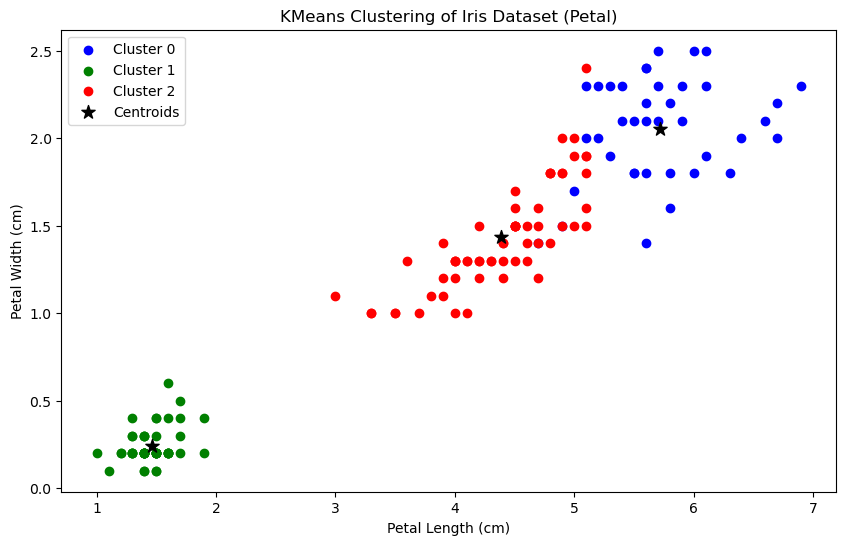

In [69]:
# Separate the dataframe into clusters for plotting.
df1 = X_km[X_km.cluster == 0]
df2 = X_km[X_km.cluster == 1]
df3 = X_km[X_km.cluster == 2]

# Plot the clusters for petal length vs petal width.
plt.figure(figsize=(10, 6))
plt.scatter(df1['petal length (cm)'], df1['petal width (cm)'], color='blue', label='Cluster 0')
plt.scatter(df2['petal length (cm)'], df2['petal width (cm)'], color='green', label='Cluster 1')
plt.scatter(df3['petal length (cm)'], df3['petal width (cm)'], color='red', label='Cluster 2')
plt.scatter(centroids[:, 2], centroids[:, 3], marker='*', color='black', s=100, label='Centroids')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.legend()
plt.title('KMeans Clustering of Iris Dataset (Petal)')
plt.show()

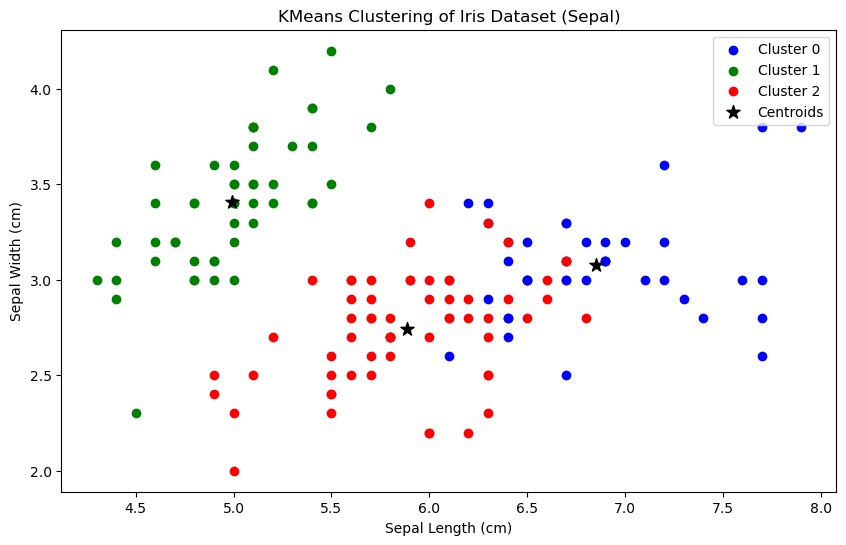

In [70]:
# Plot the clusters for sepal length vs sepal width.
plt.figure(figsize=(10, 6))
plt.scatter(df1['sepal length (cm)'], df1['sepal width (cm)'], color='blue', label='Cluster 0')
plt.scatter(df2['sepal length (cm)'], df2['sepal width (cm)'], color='green', label='Cluster 1')
plt.scatter(df3['sepal length (cm)'], df3['sepal width (cm)'], color='red', label='Cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', color='black', s=100, label='Centroids')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.legend()
plt.title('KMeans Clustering of Iris Dataset (Sepal)')
plt.show()

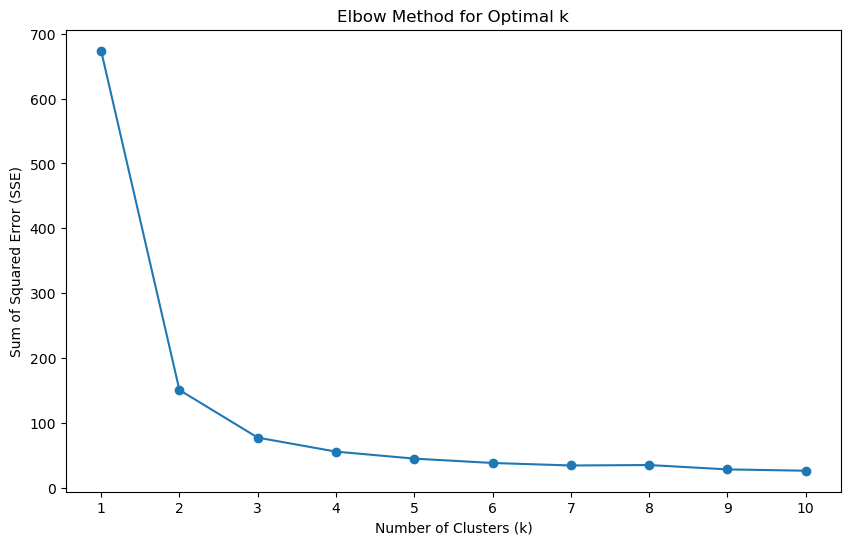

In [71]:
# Determine the optimal number of clusters using the elbow method.
# Create a list to store sum of squared errors for each k.
sse = []

# Define the range of k values to try.
k_rng = range(1, 11)

for k in k_rng:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    # Append the inertia (sum of squared errors) to the list.
    sse.append(km.inertia_)

# Plot the elbow graph.
plt.figure(figsize=(10, 6))
plt.plot(k_rng, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Error (SSE)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, 11))
plt.show()